OrderBook Demo
-------------

Examples of placing orders, fill probability estimation, and simple strategy backtests

In [1]:
#Mosie Schrem
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import OrderBook as ob
import OrderUtil as ou
import FillProbabilitySimulator as fps
import TradingStrategySimulator as tss

Examples of creating and processing orders:
--------

In [2]:
#load in intc OrderBook data
book = ob.OrderBook(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')

Create an ask order at level 2, at time 38000, reevaluating order status at every BookUpdate 

In [3]:
order = ou.BookUpdatesOrder(orderbook=book, numupdates=1, timestamp=38000, level=2, is_buy=False)
print(order.get_opening_stats())

{'price': 273800, 'start_time': 38000, 'is_buy': False, 'orderstate': 'open', 'level': 2, 'start_index': 131939}


In [4]:
#process 100 updates to orderbook
for i in range(100):
    order.update()
print(order.get_current_stats())

{'price': 273800, 'time': 38014.459199206, 'is_buy': False, 'orderstate': 'open', 'level': 2, 'current_index': 132039, 'price_delta': 0}


In [5]:
#process another 300 updates
for i in range(300):
    order.update()
print(order.get_current_stats())

{'price': 273800, 'time': 38015.006473335, 'is_buy': False, 'orderstate': 'open', 'level': 2, 'current_index': 132339, 'price_delta': 0}


In [6]:
#process until executed or cancelled
while(order.order_type('open')):
    order.update()
    
#print stats at time when order was executed
print(order.get_closing_stats())

{'price': 273800, 'time': 38167.621597535, 'is_buy': False, 'orderstate': 'executed', 'level': 1, 'end_index': 134171, 'price_delta': 0}


We can also create orders by timestep of fixed size

Create an ask order at level 2, at time 38000, reevaluating order status every 0.5 seconds

In [7]:
order = ou.TimeOrder(orderbook=book, delta_t=0.5, timestamp=38000, level=2, is_buy=False)
print(order.get_opening_stats())

{'price': 273800, 'start_time': 38000, 'is_buy': False, 'orderstate': 'open', 'level': 2, 'start_index': 131939}


In [8]:
#process 50 seconds of data
for i in range(100):
    order.update()
print(order.get_current_stats())

{'price': 273800, 'time': 38049.987429576, 'is_buy': False, 'orderstate': 'open', 'level': 3, 'current_index': 132820, 'price_delta': 0}


In [9]:
#process until executed or cancelled
while(order.order_type('open')):
    order.update()
#print stats at time when order was executed
print(order.get_closing_stats())

{'price': 273800, 'time': 38167.621597535, 'is_buy': False, 'orderstate': 'executed', 'level': 1, 'end_index': 134171, 'price_delta': 0}


Fill Probability Simulation Example:
------

In the following example, we quote buy and sell orders in the inside market, and reevaluate every 100 BookUpdates

In [10]:
probability_simulator = fps.FillProbabilitySimulator(numupdates=100, order_tuple=([1] , [1]),
                                                 orderbook=book, t_start=34200.01, t_end=50000)
probability_simulator.generate_matrices(num_samples=10000)

samples processed so far: 1000.0
samples processed so far: 2000.0
samples processed so far: 3000.0
samples processed so far: 4000.0
samples processed so far: 5000.0
samples processed so far: 6000.0
samples processed so far: 7000.0
samples processed so far: 8000.0
samples processed so far: 9000.0
samples processed so far: 10000.0


Display empirical fill probabilities for given midprice movement -1, 0, and 1

Note that bid_level_i_ask_level_j refers to bid orders filled up to level i and ask orders filled up to level j
bid_level_0 (ask_level_0) refers to no bids (asks) filled.

In [11]:
fill_matrix = probability_simulator.get_prob_matrix()
fill_matrix

y,-1,0,1
orders_executed,,,
bid_level_0_ask_level_0,0.351530,0.649865,0.337534
bid_level_0_ask_level_1,0.019196,0.138614,0.625263
bid_level_1_ask_level_0,0.582783,0.193819,0.012601
bid_level_1_ask_level_1,0.046491,0.017702,0.024602


Display frequencies of midprice movements in our sample

In [12]:
print(probability_simulator.get_quantities())

{-1: 3334, 0: 3333, 1: 3333}


Here we display the cumulative distribution of our fill probability matrix

In [13]:
cum_mat = probability_simulator.get_cum_prob_matrix()
cum_mat

y,-1,0,1
orders_executed,,,
bid_level_0_ask_level_0,1.000000,1.000000,1.000000
bid_level_0_ask_level_1,0.065687,0.156316,0.649865
bid_level_1_ask_level_0,0.629274,0.211521,0.037204
bid_level_1_ask_level_1,0.046491,0.017702,0.024602


Display PNLs

In [14]:
pnls = probability_simulator.get_pnls()
pnls

y,-1,0,1
orders placed,,,
"bids: [1], asks: [1]",-16.38,0.6,-18.66


Trading Strategy Backtest Example
----------

Here we create a basic trading strategy based on a naive mid price prediction.
Our midprice prediction is simply the previous midprice movement.

Our strategy is as follows:

When we predict an up movement, we place a bid on 1st level and an ask on the 2nd level

When we predict a down movement, we place a bid on the 2nd level and an ask on the 1st level

When we predict no movement, we place our bid and ask on inside market (1st level)

In [15]:
numupdates = 100
midprice_df = book.get_midprice_data(numupdates=100, t_end=34300)
midprice_df = midprice_df.iloc[1:]
predictions = midprice_df['y_0']
strategy = {1: ([1], [2]), 0: ([1], [1]), -1 : ([2], [1])}
backtester = tss.TradingStrategyBacktester(book=book, numupdates=100, midprice_df=midprice_df,
                                           strategy=strategy, predictions=predictions)

Run the strategy up to t = 34300

In [16]:
backtester.run_strategy()

up to update number: 0


In [17]:
pnl_series = backtester.get_pnl_series()/10000

First five lines of our profit and loss series

In [18]:
pnl_series.head()

timestamp
34201.004622    0.00
34202.208668   -0.01
34202.538824    0.00
34202.734874    0.02
34202.851101    0.04
dtype: float64

Plot Cumulative PNL

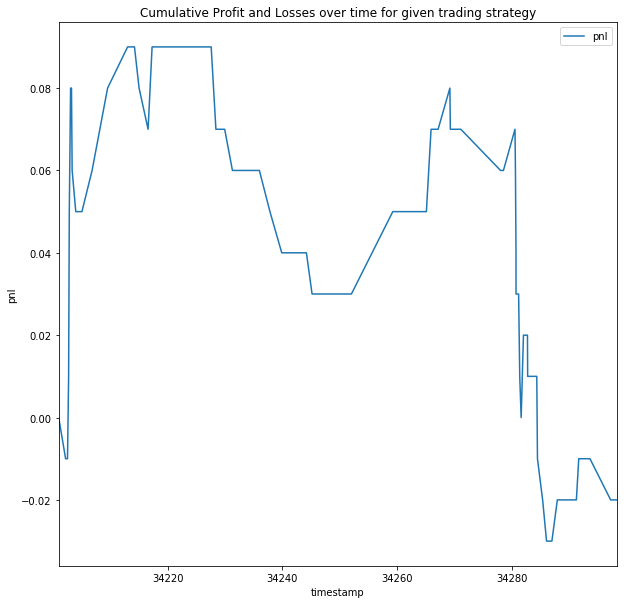

In [19]:
pnl_series.cumsum().plot()
plt.xlim(pnl_series.index.min(), pnl_series.index.max())
plt.legend(['pnl'])
plt.title('Cumulative Profit and Losses over time for given trading strategy')
plt.ylabel('pnl')
plt.show()

Loss Function Estimation (with standard midprice movement setup)
-------------

Here we approximate our loss function to feed into our Neural Network using a similar approach to the fill probability simulation.

We use the same strategy as we did for the above backtest example

In [20]:
strategy = {1: ([1], [2]), 0: ([1], [1]), -1 : ([2], [1])}
loss_func = fps.LossFunction(strategy=strategy, book=book, numupdates=100, t_end=50000, uniform_sampling=True)
loss_func.generate_loss_function_and_fill_probabilities(num_samples=10000)

simulating strategy for case yhat = 1...

samples processed so far: 1000.0
samples processed so far: 2000.0
samples processed so far: 3000.0
samples processed so far: 4000.0
samples processed so far: 5000.0
samples processed so far: 6000.0
samples processed so far: 7000.0
samples processed so far: 8000.0
samples processed so far: 9000.0
samples processed so far: 10000.0
simulating strategy for case yhat = 0...

samples processed so far: 1000.0
samples processed so far: 2000.0
samples processed so far: 3000.0
samples processed so far: 4000.0
samples processed so far: 5000.0
samples processed so far: 6000.0
samples processed so far: 7000.0
samples processed so far: 8000.0
samples processed so far: 9000.0
samples processed so far: 10000.0
simulating strategy for case yhat = -1...

samples processed so far: 1000.0
samples processed so far: 2000.0
samples processed so far: 3000.0
samples processed so far: 4000.0
samples processed so far: 5000.0
samples processed so far: 6000.0
samples proce

Loss Matrix Below based on average PNL in given case (-loss are cases where our strategy yields a profit)

In [21]:
loss_function_matrix = loss_func.get_loss_matrix()
loss_function_matrix.head()

y_true:,-1,0,1
y_predicted,,,
-1,-1.84,-0.02,20.44
0,16.51,-0.68,18.96
1,20.58,-0.05,-0.42


Fill Probabilities for each strategy

In [22]:
for key in strategy:
    print("\nFill probabilities for yhat: " + str(key) + ", and trade: " + str(strategy[key]))
    print(loss_func.get_fill_probabilities()[key])


Fill probabilities for yhat: 1, and trade: ([1], [2])
y                              -1         0         1
orders_executed                                      
bid_level_0_ask_level_0  0.366227  0.780978  0.913591
bid_level_0_ask_level_2  0.000000  0.001500  0.054905
bid_level_1_ask_level_0  0.632873  0.217522  0.022802
bid_level_1_ask_level_2  0.000900  0.000000  0.008701

Fill probabilities for yhat: 0, and trade: ([1], [1])
y                              -1         0         1
orders_executed                                      
bid_level_0_ask_level_0  0.345231  0.639664  0.328533
bid_level_0_ask_level_1  0.021896  0.141314  0.633363
bid_level_1_ask_level_0  0.585183  0.198620  0.013801
bid_level_1_ask_level_1  0.047690  0.020402  0.024302

Fill probabilities for yhat: -1, and trade: ([2], [1])
y                              -1         0         1
orders_executed                                      
bid_level_0_ask_level_0  0.913917  0.838584  0.350135
bid_level_0_ask_level_1 